The sGA best solution is: (5, [1, 1, 1, 1, 1])
The cGA best solution is: (5, [1, 1, 1, 1, 1])


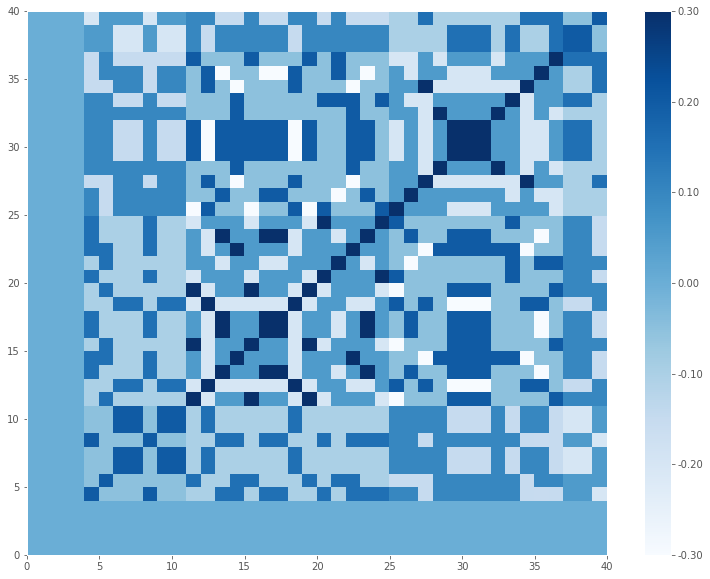

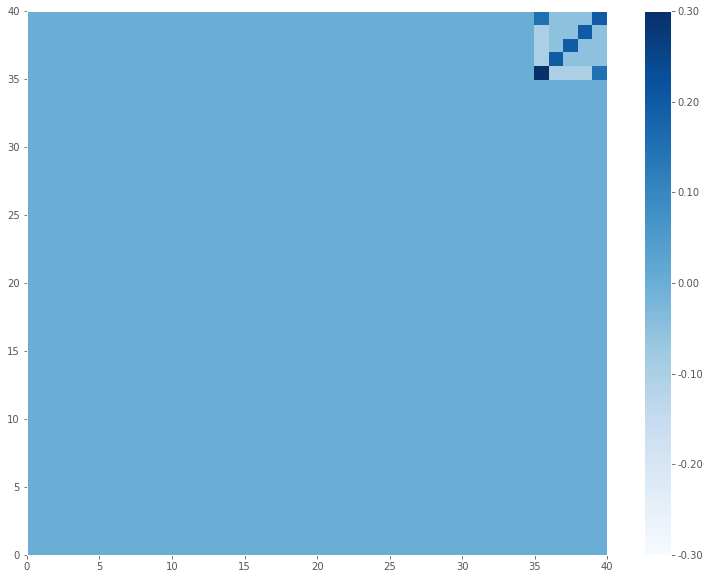

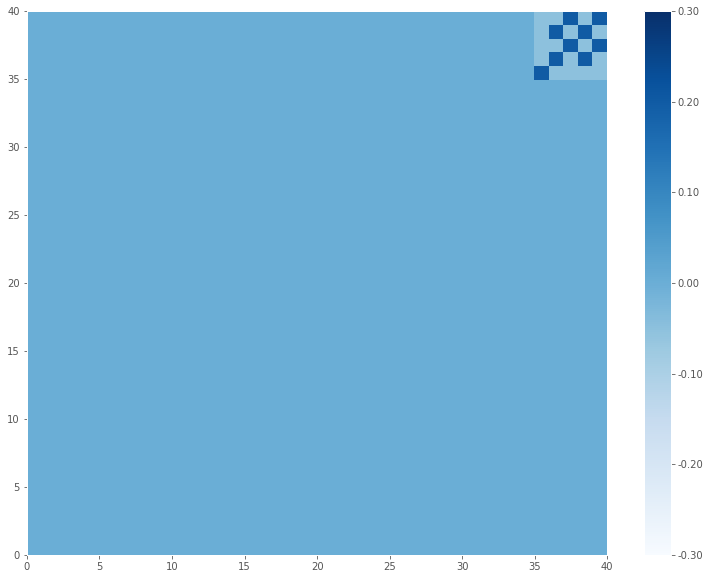

In [87]:
################################################################################
## Imports

# Importing numpy library
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
from random import random
from pyeasyga import pyeasyga
import matplotlib as mpl
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
plt.style.use('ggplot')

################################################################################
## Common code

# Data
data = [0] * 5

# Define fitness function
def fitness_function(individual, data=None):
  u = sum(individual)
  if u < 5:
    return 4 - u
  return 5

################################################################################
## Simple Genetic Algorithm (sGA)

# Initialize genetic algorithm
sga = pyeasyga.GeneticAlgorithm(data, population_size=40, generations=100)

# Set fitness function
sga.fitness_function = fitness_function

sga_cm = {}

# Set evolution function
def run(self, sga_cm):
  self.create_first_generation()
  # Initial Covariance Matrix
  arrs = [numpy.transpose(i.genes) for i in self.current_generation]
  sga_cm['sga_icm'] = numpy.cov(arrs)
  for i in range(1, self.generations):
    self.create_next_generation()
    # Intermediary
    if i == int(self.generations / 2):
      # Intermediary Covariance Matrix
      arrs = [numpy.transpose(i.genes) for i in self.current_generation]
      sga_cm['sga_tcm'] = numpy.cov(arrs)
  # Final Covariance Matrix
  arrs = [numpy.transpose(i.genes) for i in self.current_generation]
  sga_cm['sga_fcm'] = numpy.cov(arrs)
sga.run = run

# Run sGA
sga.run(sga, sga_cm)
# Get best individual
result = sga.best_individual()
# Print result
print('The sGA best solution is: {}'.format(result))

################################################################################
## Compact Genetic Algorithm (cGA)

# Initialize genetic algorithm
cga = pyeasyga.GeneticAlgorithm(data)

# Update probability vector
def update_prob(winner, loser, prob, popsize):
  for i in range(0, len(prob)):
    if winner[i] != loser[i]:
      if winner[i] == 1:
        prob[i] += 1.0 / float(popsize)
      else:
        prob[i] -= 1.0 / float(popsize)

# Create a new individual
def create_individual(prob):
  individual = []
  for p in prob:
    if random() < p:
      individual.append(1)
    else:
      individual.append(0)
  return pyeasyga.Chromosome(individual)
cga.create_individual = create_individual

# Make competition between two individuals
def compete(a, b):
  if a.fitness > b.fitness:
    return a, b
  else:
    return b, a

# Set fitness function
cga.fitness_function = fitness_function

# Set evolution function
def run(self):
  # Initialize probability vector
  prob = [0.5] * len(self.seed_data)
  # Initialize best solution
  best = None
  # Run `i` generations
  for _ in range(0, self.generations):
    # Create individuals
    a = self.create_individual(prob)
    b = self.create_individual(prob)
    # Calculate fitness for each individual
    a.fitness = self.fitness_function(a.genes)
    b.fitness = self.fitness_function(b.genes)
    # Get the best and worst individual
    winner, loser = compete(a, b)
    # Update best solution
    if best:
      if winner.fitness > best.fitness:
        best = winner
    else:
      best = winner
    # Update the probability vector based on the success of each bit
    update_prob(winner.genes, loser.genes, prob, self.population_size)
  # Add final solution
  self.current_generation.append(best)
cga.run = run

# Run evolution
cga.run(cga)
# Get best individual
result = cga.best_individual()
# Print result
print('The cGA best solution is: {}'.format(result))

################################################################################
## Heat map

def fmt(x, pos):
  return r'{:.2f}'.format(x)

hmmin, hmmax = -0.3, 0.3

fig, axis = plt.subplots(figsize=(13, 10))
heatmap = axis.pcolor(sga_cm['sga_icm'], vmin=hmmin, vmax=hmmax, cmap=plt.cm.Blues)
plt.colorbar(heatmap, format=ticker.FuncFormatter(fmt))
plt.show()

fig, axis = plt.subplots(figsize=(13, 10))
heatmap = axis.pcolor(sga_cm['sga_tcm'], vmin=hmmin, vmax=hmmax, cmap=plt.cm.Blues)
plt.colorbar(heatmap, format=ticker.FuncFormatter(fmt))
plt.show()

fig, axis = plt.subplots(figsize=(13, 10))
heatmap = axis.pcolor(sga_cm['sga_fcm'], vmin=hmmin, vmax=hmmax, cmap=plt.cm.Blues)
plt.colorbar(heatmap, format=ticker.FuncFormatter(fmt))
plt.show()

################################################################################